# Set up

In [1]:


import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os 
from utils import Experiment 
import pandas as pd

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as torch_data

from data_utils import get_depth_data, HARDataset,get_dataset 
from model_utils import * 
from utils import * 

/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_properties = {
    'harbox': {
        'n_parties': 115,
        'n_classes': 5,
        'classes': ['Walking', 'Hopping', 'Phone calls', 'Waving', 'Typing'],
    },
    'depth': {
        'n_parties': 8,
        'n_classes': 5, 
        'classes': ['Good', 'Ok', 'Victory', 'Stop', 'Fist']
    },
    'hars': {
        'n_parties': 9,
        'n_classes': 6,
        'classes': ['Walk', 'Walk up-stairs', 'Walk down-stairs',   'Sit', 'Stand','Lay']
    },
    'imu': {
        'n_parties': 6,
        'n_classes': 3, 
        'classes': ['Walking in corridor', 'Walking upstairs',  'Walking downstairs']
    }
}

# Functions

In [3]:


# a function that takes a path of .pt model and returns the torch model 
def import_model(model_template, path):
    model = copy.deepcopy(model_template)
    model.load_state_dict(torch.load(path))
    return model

# a function that takes a model, dataloader and returns the accuracy, predictions (onehot), and labels (onehot)
def evaluate(model, dataloader):
    all_preds, all_labels = [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for x, y in dataloader:
        x, y = x.to(device).float(), y.to(device).float()
        preds = model(x)[1]
        preds = preds.cpu().detach().numpy()
        all_preds.append(preds)
        all_labels.append(y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds, axis = 0)
    all_labels = np.concatenate(all_labels, axis = 0)
    preds = np.argmax(all_preds, axis = 1)
    labels = np.argmax(all_labels, axis = 1)
    return np.sum(preds == labels) / len(labels), all_preds, all_labels

# Plots

## Setup plot parameters and variables 


In [8]:
datasets = ['depth', 'hars', 'imu'] 
Cs = ['1.0', '0.5']
HTs = ['True', 'False'] 
DPs = ['True', 'False'] 
Augs = ['True', 'False'] 
Ws = [ 'uniform', 'performance_based']
aggs = ['soft_labels', 'grads']
n_pub_setss = ['1']

method1_agg = 'soft_labels'
dataset = 'harbox' 

central_train_set, central_test_set, public_set, local_sets, test_sets = get_dataset(dataset)

central_train_dataset = torch_data.TensorDataset(torch.tensor(central_train_set[0]), torch.tensor(central_train_set[1]))
central_test_dataset = torch_data.TensorDataset(torch.tensor(central_test_set[0]), torch.tensor(central_test_set[1]))
local_train_dataset = torch_data.TensorDataset(torch.tensor(local_sets[0][0]), torch.tensor(local_sets[0][1]))
local_train_dataloader = DataLoader(local_train_dataset, batch_size = 32, shuffle = True)
central_train_dataloader = DataLoader(central_train_dataset, batch_size = 32, shuffle = True)
central_test_dataloader = DataLoader(central_test_dataset, batch_size = 32, shuffle = True)


method1_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + dataset + '/' + 'Agg' + method1_agg\
             + '_C' + Cs[0] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

if not os.path.exists(method1_dir):
    print('Method 1 directory does not exist')
fl_model_path = os.path.join(method1_dir, 'client_4', 'model.pt')

model_template = get_heterogeneous_model(0, public_set[0].shape, public_set[1].shape[-1])
local_model = get_heterogeneous_model(0, public_set[0].shape, public_set[1].shape[-1])
fl_model = get_heterogeneous_model(0, public_set[0].shape, public_set[1].shape[-1])
# fl_model = import_model(model_template, fl_model_path)
critereon = torch.nn.CrossEntropyLoss()

local_opt = torch.optim.Adam(local_model.parameters(), lr = 0.001)
fl_opt = torch.optim.Adam(fl_model.parameters(), lr = 0.001)


# for epoch in range(30):
#     train(local_model, local_train_dataloader, critereon, local_opt) 

# for epoch in range(28):
#     train(fl_model, central_train_dataloader, critereon, fl_opt) 

# local_acc, local_preds, test_labels_cat = evaluate(local_model, central_test_dataloader)
# fl_acc, fl_preds, test_labels_cat2 = evaluate(fl_model, central_test_dataloader)

# print('Local model accuracy: ', local_acc)
# print('FL model accuracy: ', fl_acc)
# print(len(test_labels_cat), len(test_labels_cat2))




Method 1 directory does not exist


## Plot the dataset

/var/folders/fy/1qq1n6j95tn7gy2bwgbsqlhc0000gn/T/ipykernel_6086/2800311288.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize = 14)


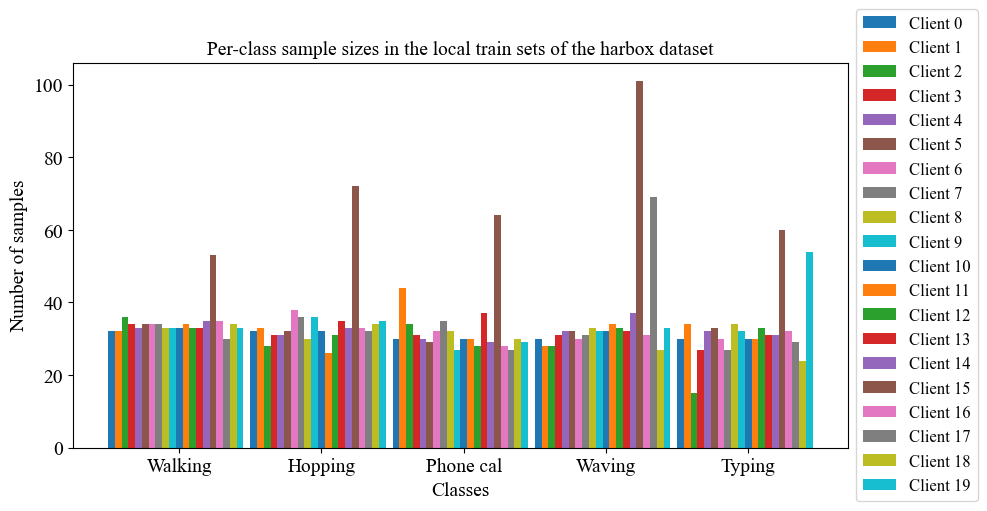

In [20]:
# a bar plot that shows the relative size of each class in the train sets of each client
def plot_class_sizes(dataset, local_sets, public_set, n_pub_sets, limit = None):
    n_pub_sets = int(n_pub_sets)
    n_classes = dataset_properties[dataset]['n_classes']
    if limit is not None:
        n_parties = min(dataset_properties[dataset]['n_parties'], limit)

    classes = dataset_properties[dataset]['classes']
    fig, ax = plt.subplots(figsize = (10, 5))
    width = 1 / (n_parties + 1)
    x = np.arange(n_classes)
    for i in range(n_parties):
            data = np.sum(local_sets[i][1], axis = 0)
            ax.bar(x + width * i, np.sum(local_sets[i][1], axis = 0), width, label = 'Client ' + str(i))
    ax.set_xlabel('Classes', fontsize = 14)
    ax.set_ylabel('Number of samples', fontsize = 14)
    ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize = 14)
    ax.set_title('Per-class sample sizes in the local train sets of the {} dataset'.format(dataset), fontsize = 14)
    ax.set_xticks(x + (width*n_parties)/2) # center xtick labels
    ax.set_xticklabels([c[:9] for c in classes], fontsize = 14)
    # ax.set_ylim([0, 2 * np.max(data)])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
    plt.show()
    # add bar labels
            
    # save as pdf 
    fig.savefig('../plots/' + dataset + '_class_sizes.pdf', bbox_inches='tight')

limit = 20
plot_class_sizes(dataset, local_sets, public_set, n_pub_setss[0], limit = limit)


## Plot spider plots

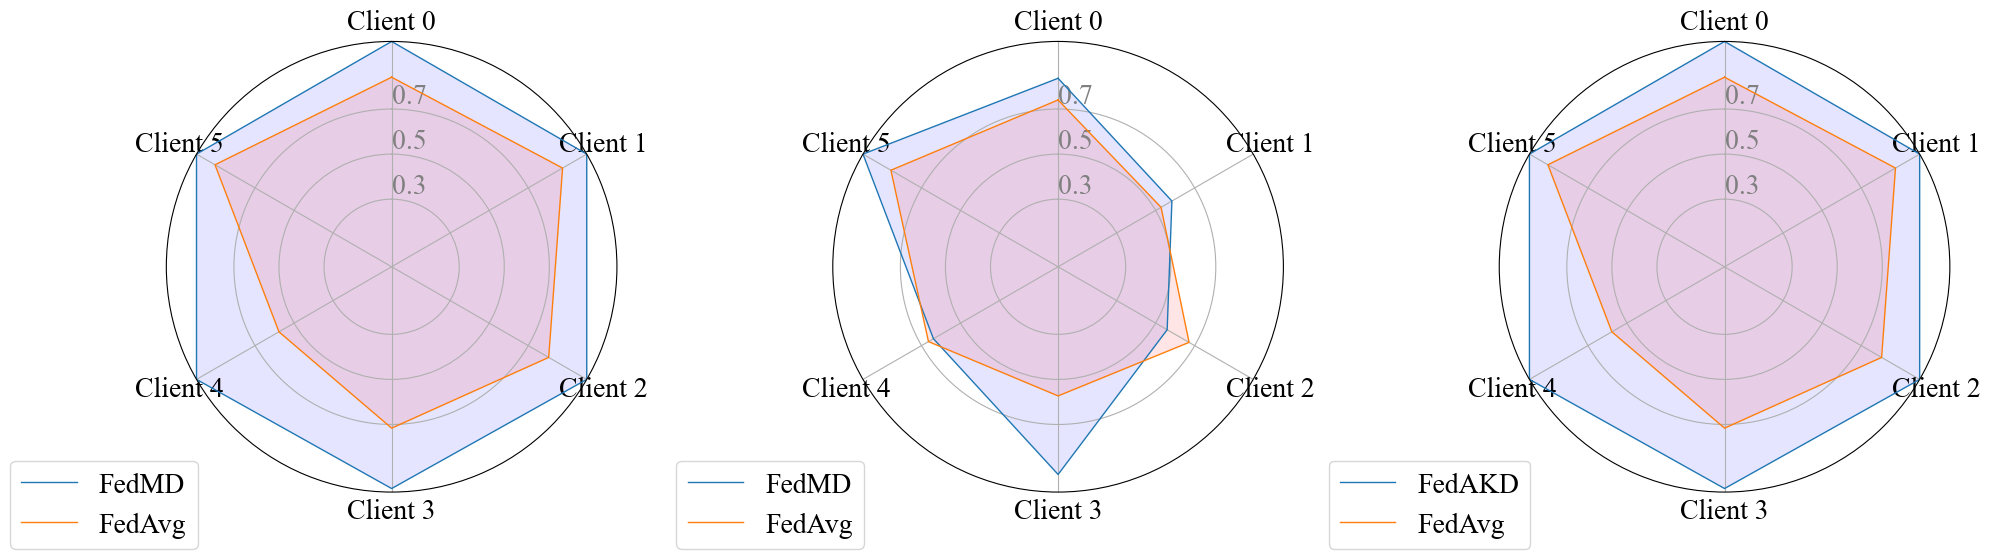

In [28]:
datasets = ['depth', 'hars', 'imu'] 
Cs = ['1.0', '0.5']
HTs = ['True', 'False'] 
DPs = ['True', 'False'] 
Augs = ['True', 'False'] 
Ws = ['uniform', 'performance_based']
aggs = ['soft_labels', 'grads']
n_pub_setss = ['1']

method1_agg = 'soft_labels'
method2_agg = 'grads'
method3_agg = 'soft_labels'
method4_agg = 'grads'
method5_agg = 'soft_labels'
method6_agg = 'grads'

dataset = 'imu'
method1_dataset = dataset 
method2_dataset = dataset
method3_dataset = dataset
method4_dataset = dataset
method5_dataset = dataset
method6_dataset = dataset


method1_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method1_dataset + '/' + 'Agg' + method1_agg\
             + '_C' + Cs[0] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

method2_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method2_dataset + '/' + 'Agg' + method2_agg\
             + '_C' + Cs[0] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

method3_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method3_dataset + '/' + 'Agg' + method3_agg\
             + '_C' + Cs[1] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

method4_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method4_dataset + '/' + 'Agg' + method4_agg\
             + '_C' + Cs[1] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

method5_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method5_dataset + '/' + 'Agg' + method5_agg\
             + '_C' + Cs[0] + '_HT' + HTs[1] + '_Aug' + Augs[0] + '_W' + Ws[0] + '/'

method6_dir = '../thesis_results' + '/DP' + DPs[1] + '/N_pub' + n_pub_setss[0] + '/' + method6_dataset + '/' + 'Agg' + method6_agg\
             + '_C' + Cs[0] + '_HT' + HTs[1] + '_Aug' + Augs[1] + '_W' + Ws[0] + '/'

method_dirs = [method1_dir, method2_dir, method3_dir, method4_dir, method5_dir, method6_dir]
for method_dir in method_dirs:

    if not os.path.exists(method_dir) :
        print('Directory does not exist: ' + method_dir)

exp1_params = {'exp_path': method1_dir, 'name': 'FedMD' , 'aggregate': method1_agg, 'C': Cs[0]}
exp2_params = { 'exp_path': method2_dir , 'name': 'FedAvg', 'aggregate': method2_agg, 'C': Cs[0]}
exp3_params = {'exp_path': method3_dir, 'name': 'FedMD' , 'aggregate': method3_agg, 'C': Cs[0]}
exp4_params = { 'exp_path': method4_dir , 'name': 'FedAvg', 'aggregate': method4_agg, 'C': Cs[0]}
exp5_params = {'exp_path': method5_dir, 'name': 'FedAKD' , 'aggregate': method5_agg, 'C': Cs[0]}
exp6_params = { 'exp_path': method6_dir , 'name': 'FedAvg', 'aggregate': method6_agg, 'C': Cs[0]}

plots_params = [
    [exp1_params, exp2_params],
    [exp3_params, exp4_params],
    [exp5_params, exp6_params]
]


label_size = 25
ticks_size = 20
legend_size = 20
plt.rcParams['xtick.labelsize'] = ticks_size
plt.rcParams['ytick.labelsize'] = ticks_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = legend_size
plt.rcParams['figure.titlesize'] = label_size


 
# # Initialise the spider plot
# ax0 = plt.subplot(121, polar=True)
# ax = plt.subplot(122, polar=True)
fig, axs = plt.subplots(1, 3, figsize=(20, 7), tight_layout=True, subplot_kw=dict(projection='polar'))


for i in range(3):
    ax = axs[i]
    exp1_params, exp2_params = plots_params[i]
    exp1 = Experiment(exp1_params).get_fl_acc(avg = False) 
    exp2 = Experiment(exp2_params).get_fl_acc(avg = False)
    df_dict = {
        'group': [exp1_params['name'], exp2_params['name']]} 
    for j in range(len(exp1)):
        df_dict['Client ' + str(j)] = [exp1[j], exp2[j]]


    df = pd.DataFrame(df_dict)
    
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    pi = np.pi
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels
    ax.set_xticks(angles[:-1], categories)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_yticks([0.3, 0.5, 0.7], ["0.3","0.5","0.7"], color="grey") 
    ax.set_ylim(0,1)
    

    # ------- PART 2: Add plots
    
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
    
    # Ind1
    values=df.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.group[0])
    ax.fill(angles, values, 'b', alpha=0.1)
    
    # Ind2
    values=df.loc[1].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.group[1])
    ax.fill(angles, values, 'r', alpha=0.1)
    
    # Add legend
    ax.legend(loc = 'best', bbox_to_anchor=(0.1, 0.1)) 

fig0 = plt.gcf()
# Show the graph
plt.show()
# save as pdf 
fig0.savefig(os.path.join("../plots", "spider_plot_D{}_W{}.pdf".format(dataset, Ws[0])), format = 'pdf', bbox_inches='tight')

## FedAvg - FedMD - FedAKD accuracy withDP/withoutDP bar plot


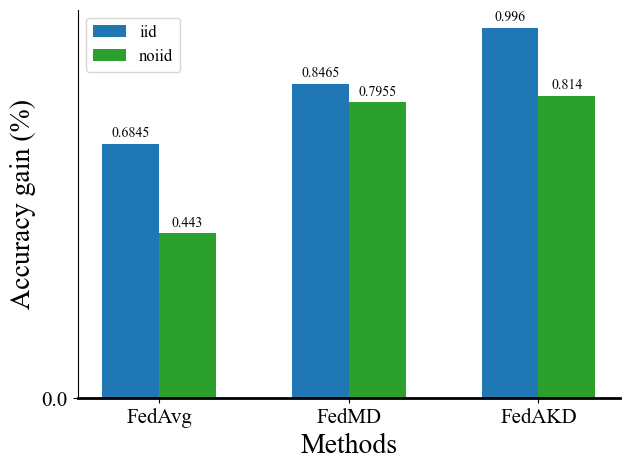

In [6]:




FL_methods = ['FedAvg', 'FedMD', 'FedAKD']

x = np.arange(len(FL_methods))  # the label locations
width = 0.3  # the width of the bars
# set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
exp_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
FedAKD = [0.6845,	0.8465,	0.996]
FedAvg =	[0.443,	0.7955,	0.814]
FedMD =	[0.597,	0.82525,	0.95925]

rects1 = ax.bar(x - width/2, FedAKD, width, label='iid', color = 'tab:blue')
rects2 = ax.bar(x + width/2, FedAvg, width, label='noiid', color = 'tab:green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Methods', fontsize = 20)
ax.set_ylabel('Accuracy gain (%)', fontsize = 20)
# ax.set_title('Average accuracy gains of FedMD vs FedAKD')

ticks = np.arange(0, 1.0, 1)
ticklabels = [str(tick) for tick in ticks]
ax.set_xticks(x, FL_methods, fontsize = 15)
ax.set_yticks(ticks) 
ax.set_yticklabels(ticklabels, fontsize = 15)
ax.legend(prop = {'size': 12})

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# remove the frame  from all sides except the bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)


# ax.set_ylim(0, 50)
fig.tight_layout()

plt.show()
# save to pdf 
fig.savefig(os.path.join('../plots', 'ALLFL_DPvsnoDP.pdf'), bbox_inches='tight')

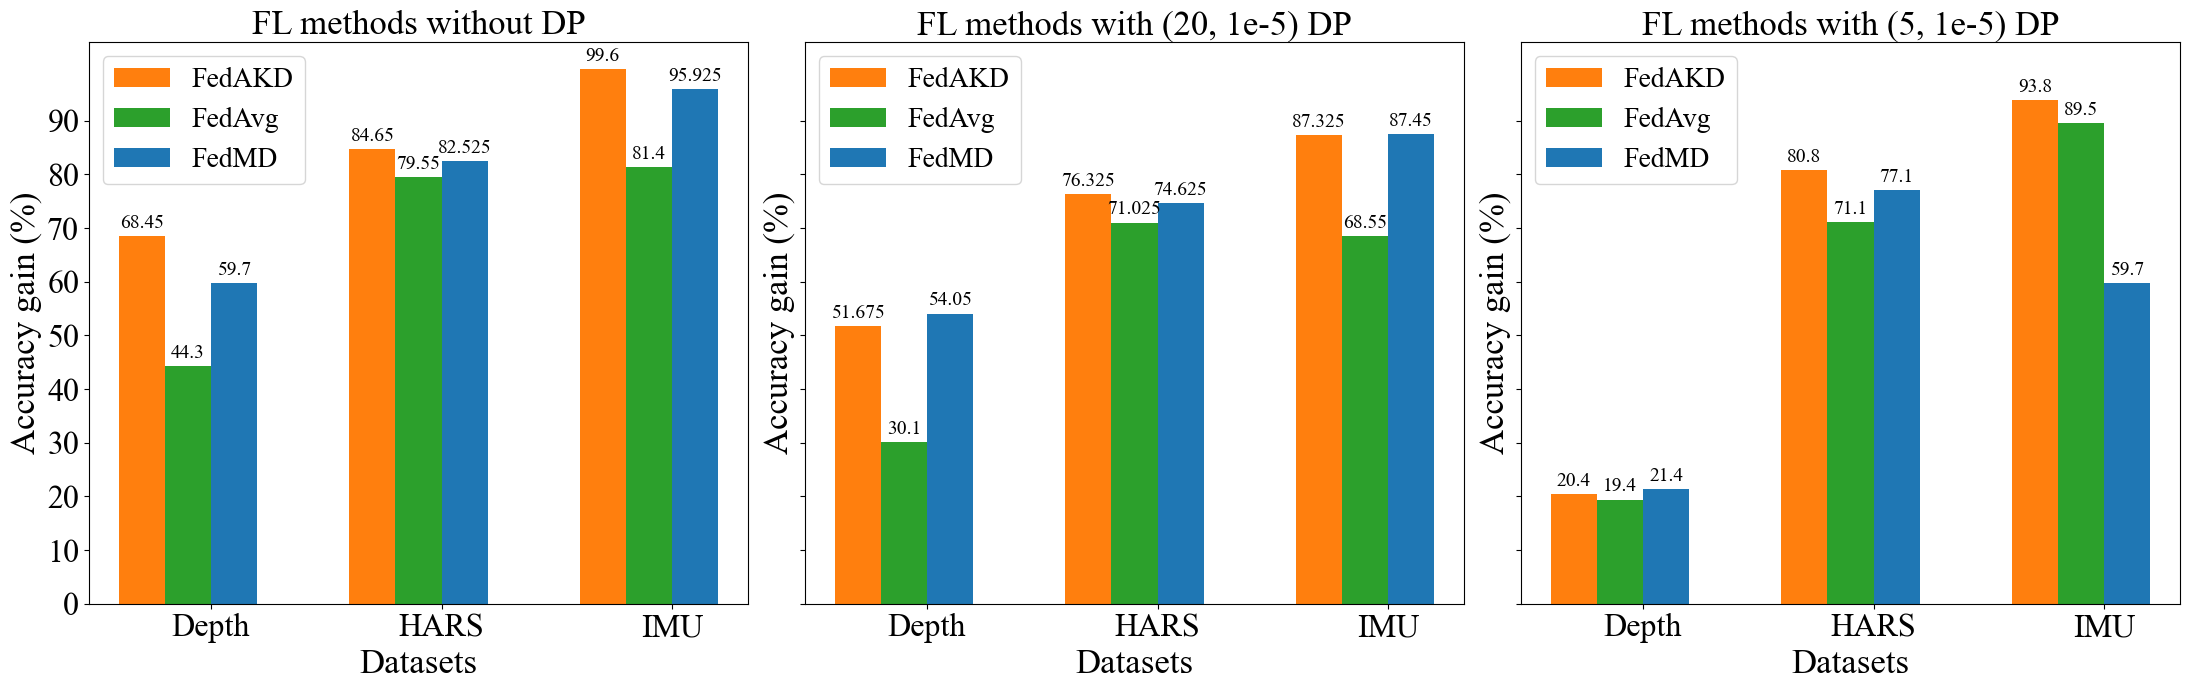

In [13]:
FL_methods = ['FedAvg', 'FedMD', 'FedAKD']
Datasets = ['Depth', 'HARS', 'IMU']
x = np.arange(len(FL_methods))  # the label locations
width = 0.3  # the width of the bars
exp_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, axs = plt.subplots(1, 3, figsize=(22, 7), sharey = True, sharex = True, tight_layout=True)

y_ticks = np.arange(0, 1, 10)
y_ticklabels = [str(tick) for tick in y_ticks]


# Data for FL methods without DP
FedAKD = [0.6845,	0.8465,	0.996]
FedAvg =	[0.443,	0.7955,	0.814]
FedMD =	[0.597,	0.82525,	0.95925]
# multiply by 100 to get the percentage
FedAKD = [i * 100 for i in FedAKD]
FedAvg = [i * 100 for i in FedAvg]
FedMD = [i * 100 for i in FedMD]
axs[0].bar(x - width, FedAKD, width*(2/3), label='FedAKD', color=exp_colors[0])
axs[0].bar(x - width*(1/3), FedAvg, width*(2/3), label='FedAvg', color=exp_colors[1])
axs[0].bar(x + width*(1/3), FedMD, width*(2/3), label='FedMD', color=exp_colors[2])
axs[0].set_xlabel('Datasets', fontsize = 25)
axs[0].set_ylabel('Accuracy gain (%)', fontsize = 25)

axs[0].set_title('FL methods without DP', fontsize = 25)
axs[0].set_xticks(x, Datasets, fontsize = 23)
# set y ticks to 0-1.0 with step 0.1 and set the fontsize to 23
axs[0].set_yticks(np.arange(0, 100, 10)) 
axs[0].set_yticklabels(np.arange(0, 100, 10), fontsize = 23)

axs[0].legend(prop = {'size': 20})



# Data for FL methods using (20, 1e-5) DP
FedAKD	= [0.51675,	0.76325,	0.87325]
FedAvg	= [0.301,	0.71025,	0.6855]
FedMD	= [0.5405,	0.74625,	0.8745]
# multiply by 100 to get percentage
FedAKD = [i * 100 for i in FedAKD]
FedAvg = [i * 100 for i in FedAvg]
FedMD = [i * 100 for i in FedMD]

axs[1].bar(x - width, FedAKD, width*(2/3), label='FedAKD', color=exp_colors[0])
axs[1].bar(x - width*(1/3), FedAvg, width*(2/3), label='FedAvg', color=exp_colors[1])
axs[1].bar(x + width*(1/3), FedMD, width*(2/3), label='FedMD', color=exp_colors[2])
axs[1].set_xlabel('Datasets', fontsize = 25)
axs[1].set_ylabel('Accuracy gain (%)', fontsize = 25)
axs[1].set_title('FL methods with (20, 1e-5) DP', fontsize = 25)
# limit the y axis to 0-100

axs[1].set_xticks(x, Datasets, fontsize = 23)
axs[1].set_yticks(np.arange(0, 100, 10)) 
axs[1].set_yticklabels(np.arange(0, 100, 10), fontsize = 23)
axs[1].legend(prop = {'size': 20})


# Data for FL methods using (5,1e-5) DP
FedAKD = [0.204,	0.808,	0.938]
FedAvg = [0.194,	0.711,	0.895]
FedMD =	[0.214,	0.771,	0.597]
# multiply by 100 to get the percentage
FedAKD = [i * 100 for i in FedAKD]
FedAvg = [i * 100 for i in FedAvg]
FedMD = [i * 100 for i in FedMD]

axs[2].bar(x - width, FedAKD, width*(2/3), label='FedAKD', color=exp_colors[0])
axs[2].bar(x - width*(1/3), FedAvg, width*(2/3), label='FedAvg', color=exp_colors[1])
axs[2].bar(x + width*(1/3), FedMD, width*(2/3), label='FedMD', color=exp_colors[2])
axs[2].set_xlabel('Datasets', fontsize = 25)
axs[2].set_ylabel('Accuracy gain (%)', fontsize = 25)
axs[2].set_title('FL methods with (5, 1e-5) DP', fontsize = 25)
# limit the y axis to 0-100

axs[2].set_xticks(x, Datasets, fontsize = 23)
axs[2].set_yticks(np.arange(0, 100, 10)) 
axs[2].set_yticklabels(np.arange(0, 100, 10), fontsize = 23)
axs[2].legend(prop = {'size': 20})


# put labels on top of the bars with font size 20
axs[0].bar_label(axs[0].containers[0], padding=3, fontsize = 14)
axs[0].bar_label(axs[0].containers[1], padding=3, fontsize = 14)
axs[0].bar_label(axs[0].containers[2], padding=3, fontsize = 14)

axs[1].bar_label(axs[1].containers[0], padding=3, fontsize = 14)
axs[1].bar_label(axs[1].containers[1], padding=3, fontsize = 14)
axs[1].bar_label(axs[1].containers[2], padding=3, fontsize = 14)

axs[2].bar_label(axs[2].containers[0], padding=3, fontsize = 14)
axs[2].bar_label(axs[2].containers[1], padding=3, fontsize = 14)
axs[2].bar_label(axs[2].containers[2], padding=3, fontsize = 14)


plt.show()
# save to pdf
fig.savefig(os.path.join('../plots', 'ALLFL_DPvsnoDP.pdf'), bbox_inches='tight')

## Accuracy boost due to scaling up the public datset

In [5]:
from itertools import product 

# central_train_set, central_test_set, public_set, local_sets, test_sets = get_dataset('harbox')

# central_train_dataset = torch_data.TensorDataset(torch.tensor(central_train_set[0]), torch.tensor(central_train_set[1]))
# central_test_dataset = torch_data.TensorDataset(torch.tensor(central_test_set[0]), torch.tensor(central_test_set[1]))
# local_train_dataset = torch_data.TensorDataset(torch.tensor(local_sets[0][0]), torch.tensor(local_sets[0][1]))
# local_train_dataloader = DataLoader(local_train_dataset, batch_size = 32, shuffle = True)
# central_train_dataloader = DataLoader(central_train_dataset, batch_size = 32, shuffle = True)
# central_test_dataloader = DataLoader(central_test_dataset, batch_size = 32, shuffle = True)

pub_sizes = [1, 4, 8]
fedakd_methods, fedmd_methods = [], []
for pub_size in pub_sizes : 
    method_dir = '../old_results' + f'/results_p{pub_size}' + '/harbox'
    
    for method in os.listdir(method_dir):
        if 'soft_labels' in method and 'AugFalse' in method:
            fedmd_methods.append(os.path.join(method_dir, method))
        elif 'soft_labels' in method and 'AugTrue' in method:
            fedakd_methods.append(os.path.join(method_dir, method))



fedakd_pub_sizes_accs_dict = {
    1: [],
    4: [], 
    8: [],
}
fedmd_pub_sizes_accs_dict = {
    1: [],
    4: [], 
    8: [],
}
for pub_size in pub_sizes : 
    for method in fedakd_methods : 
        if f'p{pub_size}' in method : 
            fedakd_exp_params = {'exp_path': method, 'name': 'FedAKD' , 'aggregate': 'soft_labels', 'C': 0.5}
            try : 
                acc = Experiment(fedakd_exp_params).get_fl_acc(avg = True)
                fedakd_pub_sizes_accs_dict[pub_size].append(acc)
            except : 
                continue 

    for method in fedmd_methods :
        if f'p{pub_size}' in method : 
            fedmd_exp_params = {'exp_path': method, 'name': 'FedMD' , 'aggregate': 'soft_labels', 'C': 0.5}
            try : 
                acc = Experiment(fedmd_exp_params).get_fl_acc(avg = True)
                fedmd_pub_sizes_accs_dict[pub_size].append(acc)
            except : 
                continue 

fedakd_pub_sizes_accs_dict = {k: np.mean(v) for k, v in fedakd_pub_sizes_accs_dict.items()}
fedmd_pub_sizes_accs_dict = {k: np.mean(v) for k, v in fedmd_pub_sizes_accs_dict.items()}
fedakd_pub_sizes_accs_dict, fedmd_pub_sizes_accs_dict



({1: 0.8218032579648415, 4: 0.8993332446994704, 8: 0.8950888929622476},
 {1: 0.8015044429739068, 4: 0.8866845969188076, 8: 0.8797951282109893})

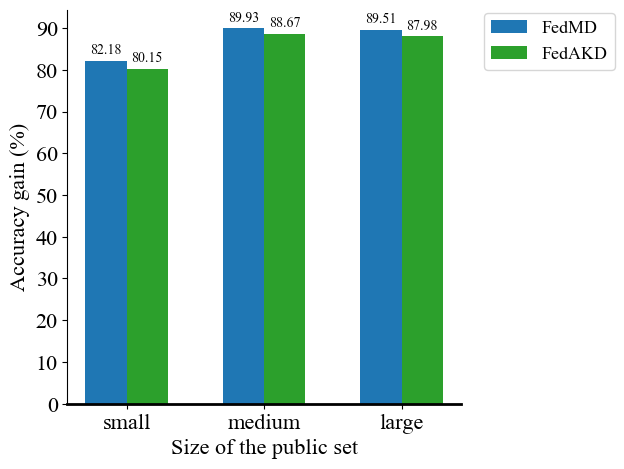

In [7]:




FL_methods = ['FedAvg', 'FedMD', 'FedAKD']
Datasets = ['Depth', 'HARS', 'IMU']
public_set_size_names = ['small', 'medium', 'large']
x = np.arange(len(FL_methods))  # the label locations
width = 0.3  # the width of the bars
# set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
exp_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
FedAKD = [round(x *  100, 2) for x in  list(fedakd_pub_sizes_accs_dict.values())]
FedMD =	[round(x *  100, 2) for x in list(fedmd_pub_sizes_accs_dict.values())]


rects1 = ax.bar(x - width/2, FedAKD, width, label='FedMD', color = 'tab:blue')
rects2 = ax.bar(x + width/2, FedMD, width, label='FedAKD', color = 'tab:green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Size of the public set', fontsize = 16)
ax.set_ylabel('Accuracy gain (%)', fontsize = 16)
# ax.set_title('Average accuracy gains of FedMD vs FedAKD')

ticks = np.arange(0, 1.0, 1)
ticklabels = [str(tick) for tick in ticks]
ax.set_xticks(x, public_set_size_names, fontsize = 16)
ax.set_yticks(np.arange(0, 100, 10)) 
ax.set_yticklabels(np.arange(0, 100, 10), fontsize = 16)
ax.legend(prop = {'size': 13}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# remove the frame  from all sides except the bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)


# ax.set_ylim(0, 50)
fig.tight_layout()

plt.show()

# save to pdf 
fig.savefig(os.path.join('../plots', 'Scaling_pub_acc.pdf'), bbox_inches='tight')


## Embeddings of FL models vs Local models 

In [129]:
# create decision surface
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

def get_embeds(model, dataloader) :
    all_embeds = [] 
    model.eval()
    
    acc, preds, labels = evaluate(model, dataloader) 
    return preds 

def get_pca_embeds(model, fit_data, transform_data) :
    pca = PCA(n_components=2)
    pca.fit(get_embeds(model, fit_data))
    return pca.transform(get_embeds(model, transform_data))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_on = central_train_dataloader
test_on = central_test_dataloader

local_test_embeds = get_pca_embeds(local_model, fit_data = train_on, transform_data = test_on)
fl_test_embeds = get_pca_embeds(fl_model, fit_data = train_on, transform_data = test_on)


local_lr_model = LogisticRegression().fit(local_test_embeds, np.argmax(central_test_set[1], -1)) 
fl_lr_model = LogisticRegression().fit(fl_test_embeds, np.argmax(central_test_set[1], -1))
local_embeds_limits = (local_test_embeds.min(axis=0) - 0.1, local_test_embeds.max(axis=0) + 0.1)
fl_embeds_limits = (fl_test_embeds.min(axis=0), fl_test_embeds.max(axis=0))
grid_limits = (np.min([local_embeds_limits[0], fl_embeds_limits[0]], axis=0), np.max([local_embeds_limits[1], fl_embeds_limits[1]], axis=0))
xx, yy = np.meshgrid(np.linspace(grid_limits[0][0], grid_limits[1][0], 100), np.linspace(grid_limits[0][1], grid_limits[1][1], 100))
background_points = np.array([xx.ravel(), yy.ravel()]).T
local_cover_preds = local_lr_model.predict(torch.from_numpy(background_points).to(device)).reshape(xx.shape)
fl_cover_preds = fl_lr_model.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

01/27/2023 15:03:53:WARNING:*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
01/27/2023 15:03:53:WARNING:*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
01/27/2023 15:03:53:WARNING:*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

ys (2947,)


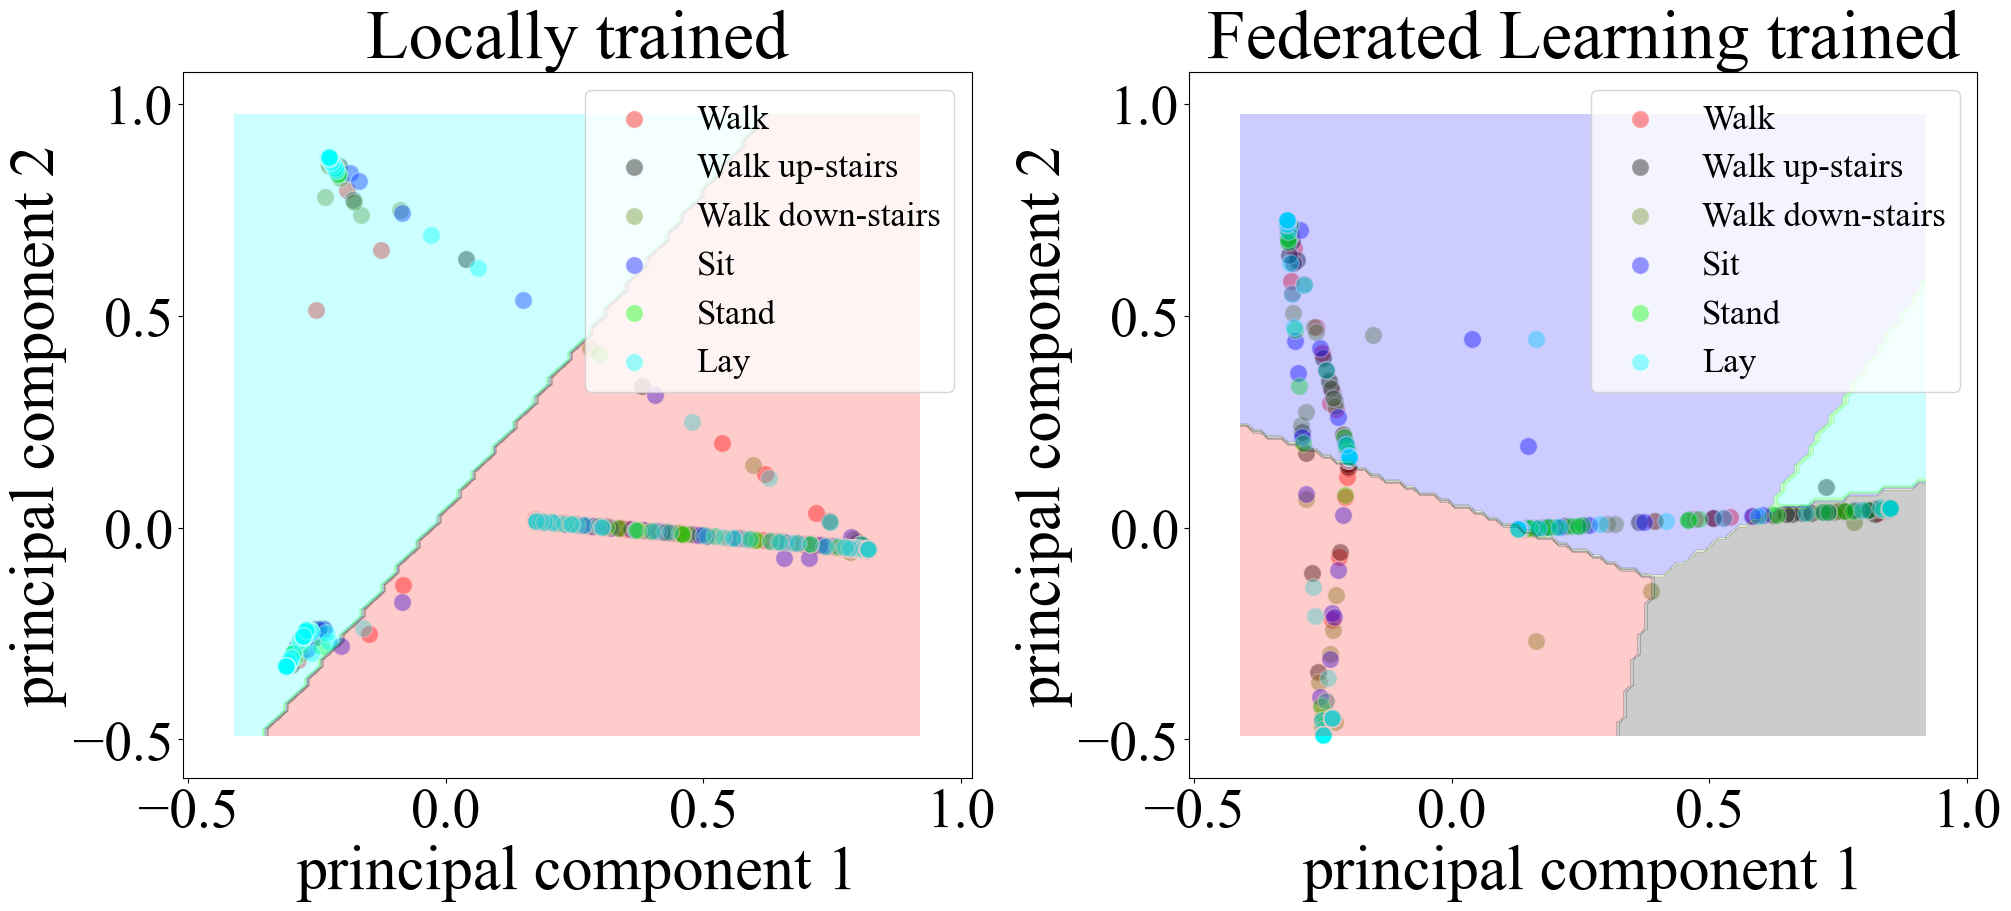

In [130]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
# red = (255/255, 0/255, 0/255)
yellow = (255/255, 255/255, 0/255)
orange = (255/255, 165/255, 0/255)
strange_color = (255/255, 0/255, 255/255) 
cyan = (0/255, 255/255, 255/255)
green = (0, 255/255, 0)
gold = (255/255, 215/255, 0)

red = (255/255, 0, 0)
black = (0, 0, 0)
olive = (107/255, 142/255, 35/255)
blue = (0, 0, 255/255)

# tab colors (e.g. tab:blue) 
tab_blue = (0, 0, 139/255)
tab_orange = (255/255, 140/255, 0)
tab_green = (0, 100/255, 0)
tab_red = (255/255, 0, 0)
tab_purple = (128/255, 0, 128/255)
tab_brown = (165/255, 42/255, 42/255)
tab_pink = (255/255, 192/255, 203/255)
tab_gray = (128/255, 128/255, 128/255)

newcolors = np.vstack((red, black, olive, blue, green, cyan))
tabcolors = np.vstack((tab_blue, tab_orange, tab_green, tab_red, tab_purple, tab_brown, tab_pink, tab_gray))
cmap = ListedColormap(newcolors, name='OliveBlackCyan')
tabcmap = ListedColormap(tabcolors, name='tabcolors')


# bcmap = cm.get_cmap('Greys')
# make cmap lighter 
bcmap = cmap 


ys = np.argmax(central_test_set[1], -1)
# shuffle ys, embeds
perm = np.random.permutation(len(ys))
ys = ys[perm]
local_test_embeds = local_test_embeds[perm, :]
fl_test_embeds = fl_test_embeds[perm, :]

print("ys", ys.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 9), constrained_layout=True)
# local_model_classes = parties_classes[3] 

n_parties = dataset_properties[dataset]['n_parties']
n_classes = dataset_properties[dataset]['n_classes']
classes = dataset_properties[dataset]['classes']

limit = 4000
local_test_embeds_sample = local_test_embeds[:limit, :]
fl_test_embeds_sample = fl_test_embeds[:limit, :]
ys_sample = ys[:limit]
for i, label in enumerate(classes) :     
    axs[0].scatter(x=local_test_embeds_sample[ys_sample == i, 0], y=local_test_embeds_sample[ys_sample == i, 1], c = bcmap.colors[i], label = label, s = 160, alpha = 0.4, edgecolors='w')
    axs[1].scatter(x=fl_test_embeds_sample[ys_sample == i, 0], y=fl_test_embeds_sample[ys_sample == i, 1], c = bcmap.colors[i], label = label, s = 160, alpha = 0.4, edgecolors='w')


csfont = {'fontname':'Times New Roman'}
title_size = 50 
label_size = 45
legend_font_dict = {'size': 25}
ticks_size = 40

axs[0].contourf(xx, yy, local_cover_preds,  alpha=0.2, cmap = bcmap)
axs[0].set_xlabel('principal component 1', fontsize = label_size, **csfont)
axs[0].set_ylabel('principal component 2', fontsize = label_size, **csfont)
axs[0].set_title('Locally trained', fontsize = title_size, **csfont)

axs[0].tick_params(axis='both', which='major', labelsize=ticks_size)
# limit the x and y axis to a little bit more than the data
axs[0].set_xlim(grid_limits[0][0] - 0.1, grid_limits[1][0] + 0.1)
axs[0].set_ylim(grid_limits[0][1] - 0.1, grid_limits[1][1] + 0.1)
# set xlim and ylim
# axs[0].set_xlim(-0.3, 0.3)
# axs[0].set_ylim(-0.3, 0.3)
axs[0].legend(prop = legend_font_dict)

axs[1].contourf(xx, yy, fl_cover_preds, alpha=0.2, cmap = bcmap)
axs[1].set_xlabel('principal component 1', fontsize = label_size, **csfont)
axs[1].set_ylabel('principal component 2', fontsize = label_size, **csfont)
axs[1].set_title('Federated Learning trained', fontsize = title_size, **csfont)
axs[1].tick_params(axis='both', which='major', labelsize=ticks_size)
# limit the x and y axis to a little bit more than the data
axs[1].set_xlim(grid_limits[0][0] - 0.1, grid_limits[1][0] + 0.1)
axs[1].set_ylim(grid_limits[0][1] - 0.1, grid_limits[1][1] + 0.1)
# set xlim and ylim
# axs[1].set_xlim(-0.7, 0.7)
# axs[1].set_ylim(-0.7, 0.7)
axs[1].legend(prop = legend_font_dict)

# annotate each plot with a unique letter
# axs[0].text(-0.9, 0.9, 'A', fontsize = 40, **csfont)
# axs[1].text(-0.9, 0.9, 'B', fontsize = 40, **csfont)



# print accuracy
# print('classifier Accuracy on best model pca embeddings: ', np.sum(local_lr_model.predict(local_test_embeds) == ys) / len(ys))
# print('classifier Accuracy on worst model pca embeddings: ', np.sum(fl_lr_model.predict(fl_test_embeds) == ys) / len(ys))

# write accuray on plot
# axs[0].text(-0.9, -0.9, 'Accuracy: {:.2f}'.format(np.sum(np.argmax(local_model.predict(test_data[0]), axis = -1) == ys) / len(ys)), fontsize = 15, **csfont)
# axs[1].text(-0.9, -0.9, 'Accuracy: {:.2f}'.format(np.sum(np.argmax(fl_model.predict(test_data[0]), axis = -1) == ys) / len(ys)), fontsize = 15, **csfont)
# axs[2].text(0.9, -0.9, 'Accuracy: {:.2f}'.format(np.sum(worst_tmp_model.predict(worst_embeds) == test_num_labels) / len(test_num_labels)), fontsize = 15, **csfont)

plt.show()
# save the file as pdf
fig.savefig('../plots/FL_vs_Local_embeds_{}.pdf'.format(dataset), bbox_inches='tight')

## Roc curve of FL models vs Local models

(2947, 6)
(2947, 6)
(2947, 6)


/var/folders/fy/1qq1n6j95tn7gy2bwgbsqlhc0000gn/T/ipykernel_22698/3987952644.py:104: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
/var/folders/fy/1qq1n6j95tn7gy2bwgbsqlhc0000gn/T/ipykernel_22698/3987952644.py:106: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
/var/folders/fy/1qq1n6j95tn7gy2bwgbsqlhc0000gn/T/ipykernel_22698/3987952644.py:108: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
/var/folders/fy/1qq1n6j95tn7gy2bwgbsqlhc0000gn/T/ipykernel_22698/3987952644.py:110: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


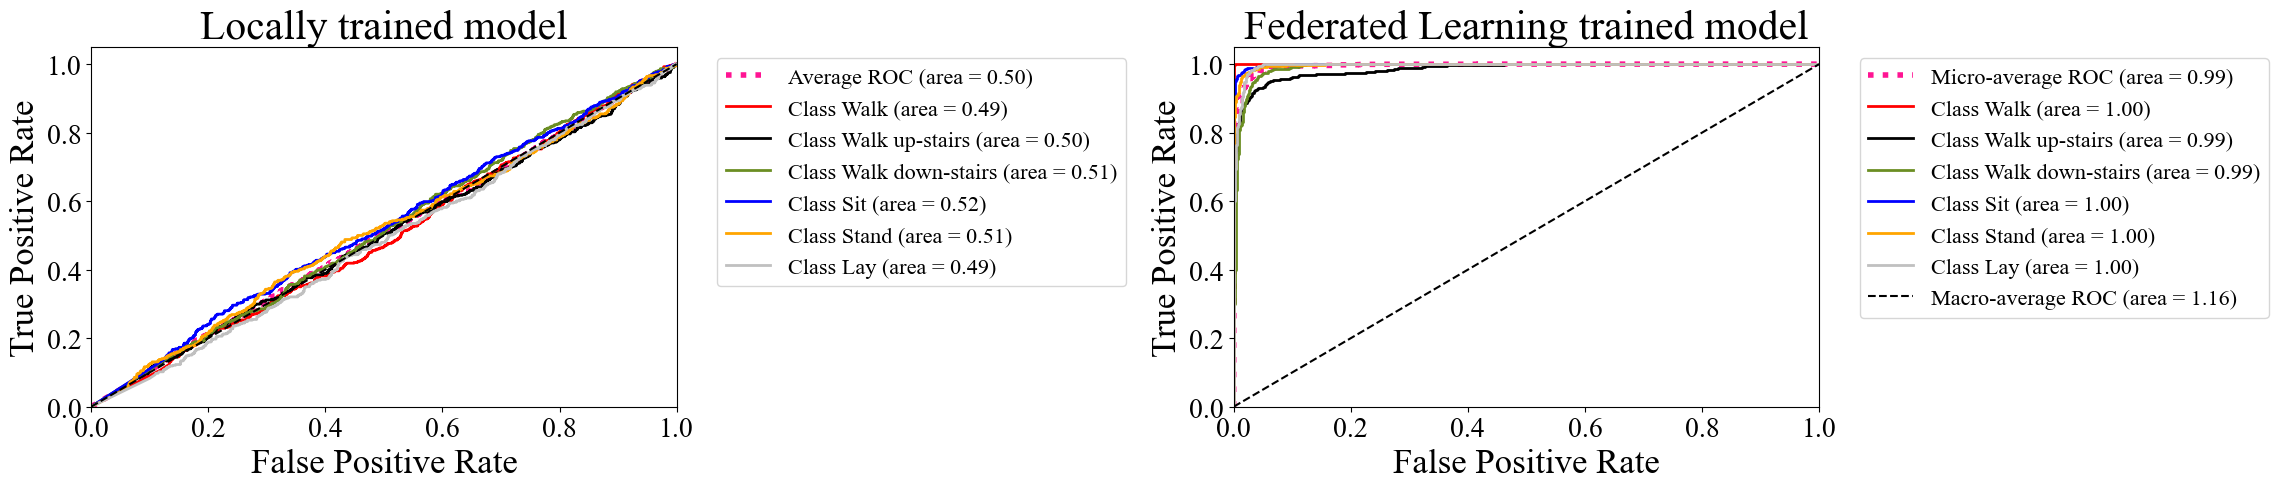

93.14557176789955


In [131]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

red = (255/255, 0, 0)
black = (0, 0, 0)
olive = (107/255, 142/255, 35/255)
blue = (0, 0, 255/255)
orange = (255/255, 165/255, 0)
silver = (192/255, 192/255, 192/255)
class_colors = [red, black, olive, blue, orange, silver]

def compare_roc_curve(model1_preds, model1_ground_truth, model2_preds, model2_ground_truth, original_labels, titles, dataset):
    n_classes = len(original_labels)
    # Compute ROC curve and ROC area for each class of model 1
    model1_fpr = dict()
    model1_tpr = dict()
    model1_roc_auc = dict()
    for i in range(n_classes):
        model1_fpr[i], model1_tpr[i], _ = roc_curve(model1_ground_truth[:, i], model1_preds[:, i])
        model1_roc_auc[i] = auc(model1_fpr[i], model1_tpr[i])

    # Compute micro-average ROC curve and ROC area of model 1
    model1_fpr["micro"], model1_tpr["micro"], _ = roc_curve(model1_ground_truth.ravel(), model1_preds.ravel())
    model1_roc_auc["micro"] = auc(model1_fpr["micro"], model1_tpr["micro"])

    # Compute ROC curve and ROC area for each class of model 2
    model2_fpr = dict()
    model2_tpr = dict()
    model2_roc_auc = dict()
    for i in range(n_classes):
        model2_fpr[i], model2_tpr[i], _ = roc_curve(model2_ground_truth[:, i], model2_preds[:, i])
        model2_roc_auc[i] = auc(model2_fpr[i], model2_tpr[i])

    # Compute micro-average ROC curve and ROC area of model 2
    model2_fpr["micro"], model2_tpr["micro"], _ = roc_curve(model2_ground_truth.ravel(), model2_preds.ravel())
    model2_roc_auc["micro"] = auc(model2_fpr["micro"], model2_tpr["micro"])



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

    # Plot micro-average ROC curve
    ax1.plot(model1_fpr["micro"], model1_tpr["micro"],
                label='Average ROC (area = {0:0.2f})'
                    ''.format(model1_roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    for i in range(n_classes):
        ax1.plot(model1_fpr[i], model1_tpr[i], color = class_colors[i], label='Class {0} (area = {1:0.2f})'
                                                ''.format(original_labels[i], model1_roc_auc[i]), linewidth=2)

    # Plot macro-average ROC curve
    macro_roc_auc = sum(model1_roc_auc.values()) / n_classes
    ax1.plot([0, 1], [0, 1], 'k--')

    label_font_dict = {'size': 25}
    legend_font_dict = {'size': 16}
    title_font_dict = {'size': 30}

    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', label_font_dict, **csfont)
    ax1.set_ylabel('True Positive Rate', label_font_dict, **csfont) 
    ax1.set_title(titles[0], title_font_dict, **csfont)
    # ax1.legend(loc="lower right", prop = legend_font_dict) 


    # Plot micro-average ROC curve
    ax2.plot(model2_fpr["micro"], model2_tpr["micro"],
                label='Micro-average ROC (area = {0:0.2f})'
                    ''.format(model2_roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    for i in range(n_classes):
        ax2.plot(model2_fpr[i], model2_tpr[i], label='Class {0} (area = {1:0.2f})'
                                                ''.format(original_labels[i], model2_roc_auc[i]), color = class_colors[i], linewidth=2)

    # Plot macro-average ROC curve
    macro_roc_auc = sum(model2_roc_auc.values()) / n_classes
    ax2.plot([0, 1], [0, 1], 'k--', label='Macro-average ROC (area = {0:0.2f})'.format(macro_roc_auc))

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', label_font_dict, **csfont) 
    ax2.set_ylabel('True Positive Rate', label_font_dict, **csfont)
    ax2.set_title(titles[1], title_font_dict, **csfont)
    # ax2.legend(loc="lower right",   legend_font_dict)

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), prop = legend_font_dict)
    ax2.legend(loc="upper left", bbox_to_anchor=(1.05, 1), prop = legend_font_dict)

    # annotate each graph with a unique letter
    # ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes,
    #         fontsize=30, fontweight='bold', va='top', ha='right')
    # ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes,
    #         fontsize=30, fontweight='bold', va='top', ha='right')
    

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
        
    fig.tight_layout()
    plt.show()
    # save the file as pdf 
    fig.savefig('../plots/{}compare_roc_curve.pdf'.format(dataset), bbox_inches='tight')


print(central_test_set[1].shape) 
print(fl_preds.shape)
print(fl_preds.shape)
titles = [
    'Locally trained model',
    'Federated Learning trained model',
]
compare_roc_curve(fl_preds, test_labels_cat, local_preds, test_labels_cat, classes, titles, dataset)

fl_acc, fl_preds, _ = evaluate(fl_model, central_test_dataloader)
print(fl_acc * 100)

## Accuracy of FedMD/FedAKD using public dataset of different distribution than the private dataset

['../results_HARBOX_IMU/N_pub1/harbox/Aggsoft_labels_C1.0_HTFalse_AugTrue_Wunifrom', '../results_HARBOX_IMU/N_pub1/harbox/Aggsoft_labels_C1.0_HTFalse_AugTrue_Wperformance_based', '../results_HARBOX_IMU/N_pub4/harbox/Aggsoft_labels_C1.0_HTFalse_AugTrue_Wunifrom', '../results_HARBOX_IMU/N_pub4/harbox/Aggsoft_labels_C1.0_HTFalse_AugTrue_Wperformance_based']
['../results_HARBOX_IMU/N_pub1/harbox/Aggsoft_labels_C1.0_HTFalse_AugFalse_Wperformance_based', '../results_HARBOX_IMU/N_pub1/harbox/Aggsoft_labels_C1.0_HTFalse_AugFalse_Wunifrom', '../results_HARBOX_IMU/N_pub4/harbox/Aggsoft_labels_C1.0_HTFalse_AugFalse_Wperformance_based', '../results_HARBOX_IMU/N_pub4/harbox/Aggsoft_labels_C1.0_HTFalse_AugFalse_Wunifrom']
[86.46, 85.77]
[85.19, 85.15]


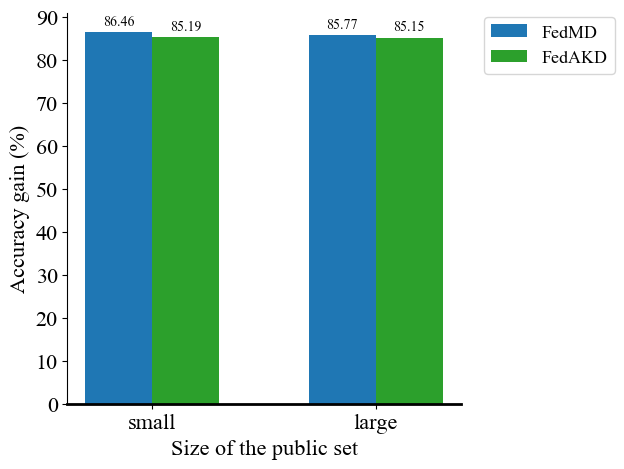

In [16]:
## Accuracy boost due to scaling up the public datset
from itertools import product 

# central_train_set, central_test_set, public_set, local_sets, test_sets = get_dataset('harbox')

# central_train_dataset = torch_data.TensorDataset(torch.tensor(central_train_set[0]), torch.tensor(central_train_set[1]))
# central_test_dataset = torch_data.TensorDataset(torch.tensor(central_test_set[0]), torch.tensor(central_test_set[1]))
# local_train_dataset = torch_data.TensorDataset(torch.tensor(local_sets[0][0]), torch.tensor(local_sets[0][1]))
# local_train_dataloader = DataLoader(local_train_dataset, batch_size = 32, shuffle = True)
# central_train_dataloader = DataLoader(central_train_dataset, batch_size = 32, shuffle = True)
# central_test_dataloader = DataLoader(central_test_dataset, batch_size = 32, shuffle = True)

pub_sizes = [1, 4]
fedakd_methods, fedmd_methods = [], []
for pub_size in pub_sizes : 
    method_dir = '../results_HARBOX_IMU' + f'/N_pub{pub_size}' + '/harbox'
    
    for method in os.listdir(method_dir):
        if 'soft_labels' in method and 'AugFalse' in method:
            fedmd_methods.append(os.path.join(method_dir, method))
        elif 'soft_labels' in method and 'AugTrue' in method:
            fedakd_methods.append(os.path.join(method_dir, method))

print(fedakd_methods)
print(fedmd_methods)

fedakd_pub_sizes_accs_dict = {
    1: [],
    4: [],
}
fedmd_pub_sizes_accs_dict = {
    1: [],
    4: [], 
}
for pub_size in pub_sizes : 
    for method in fedakd_methods : 
        if f'N_pub{pub_size}' in method : 
            fedakd_exp_params = {'exp_path': method, 'name': 'FedAKD' , 'aggregate': 'soft_labels', 'C': 0.5}
            try : 
                acc = Experiment(fedakd_exp_params).get_fl_acc(avg = True)
                fedakd_pub_sizes_accs_dict[pub_size].append(acc)
            except : 
                continue 

    for method in fedmd_methods :
        if f'N_pub{pub_size}' in method : 
            fedmd_exp_params = {'exp_path': method, 'name': 'FedMD' , 'aggregate': 'soft_labels', 'C': 0.5}
            try : 
                acc = Experiment(fedmd_exp_params).get_fl_acc(avg = True)
                fedmd_pub_sizes_accs_dict[pub_size].append(acc)
            except : 
                continue 

fedakd_pub_sizes_accs_dict = {k: np.mean(v) for k, v in fedakd_pub_sizes_accs_dict.items()}
fedmd_pub_sizes_accs_dict = {k: np.mean(v) for k, v in fedmd_pub_sizes_accs_dict.items()}




FL_methods = ['FedMD', 'FedAKD']
Datasets = ['Depth', 'HARS', 'IMU']
public_set_size_names = ['small', 'large']
x = np.arange(len(FL_methods))  # the label locations
width = 0.3  # the width of the bars
# set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
exp_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
FedAKD = [round(x *  100, 2) for x in  list(fedakd_pub_sizes_accs_dict.values())]
FedMD =	[round(x *  100, 2) for x in list(fedmd_pub_sizes_accs_dict.values())]

print(FedAKD)
print(FedMD)

rects1 = ax.bar(x - width/2, FedAKD, width, label='FedMD', color = 'tab:blue')
rects2 = ax.bar(x + width/2, FedMD, width, label='FedAKD', color = 'tab:green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Size of the public set', fontsize = 16)
ax.set_ylabel('Accuracy gain (%)', fontsize = 16)
# ax.set_title('Average accuracy gains of FedMD vs FedAKD')

ticks = np.arange(0, 1.0, 1)
ticklabels = [str(tick) for tick in ticks]
ax.set_xticks(x, public_set_size_names, fontsize = 16)
ax.set_yticks(np.arange(0, 100, 10)) 
ax.set_yticklabels(np.arange(0, 100, 10), fontsize = 16)
ax.legend(prop = {'size': 13}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# remove the frame  from all sides except the bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)


# ax.set_ylim(0, 50)
fig.tight_layout()

plt.show()

# save to pdf 
fig.savefig(os.path.join('../plots', 'different_pub_acc.pdf'), bbox_inches='tight')
